### Prepare Programming Environment

In [848]:
# Import libraries
import pandas as pd # Dataframe
import numpy as np # Math
import seaborn as sns # Graphs
import matplotlib.pyplot as plt # Graphs
import random # Randomness

sd = 666

random.seed(sd) #666 #231 #275

### Data Exploration

In [849]:
# Load dataset: Iris
columns = ["sepal length","sepal width","petal length","petal width", "class"]
df = pd.read_csv('iris.data', names = columns)
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [850]:
# Explore dataset
df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [851]:
# Check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


d:\Program Files (x86)\Python 3.11.0\Lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


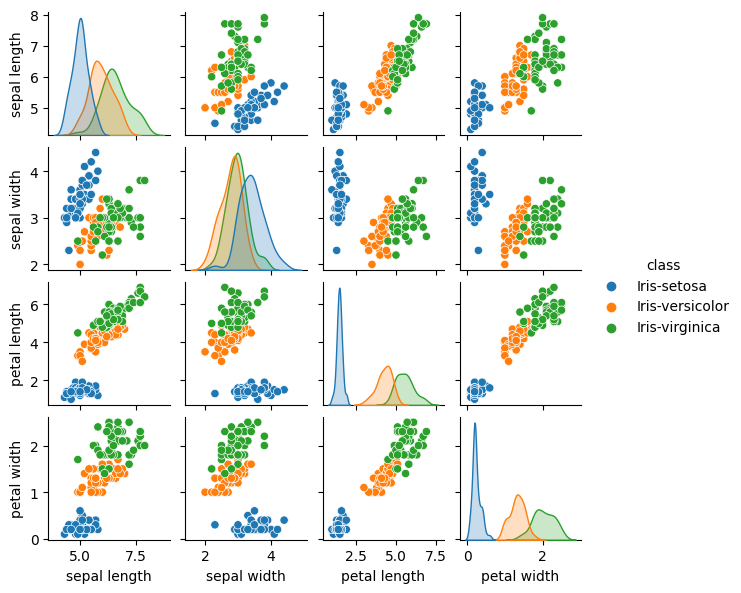

In [852]:
# Check for linear separability
sns.pairplot(df, hue='class', size=1.5);

In [853]:
# Check target balance
df["class"].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: class, dtype: int64

### Model Design

- Chosen Model: SVM
- 3 Target Classes $\therefore$ One vs One multiclass classification
- No Linear Separability $\therefore$ Soft margin
- Balanced Target Classes $\therefore$ Evaluation metric: accuracy
- Math:
    - Hiperplane: $\omega \cdot x - b = 0$
    - Classes: $y \in \{ -1, 1 \}$ (Mapped to positive class and negative class)
    - Margin Contraint: $y_i ( \omega \cdot x_i - b ) \geq 1$
    - Loss Function: Hinge Loss: $l = \max (0, 1 - y_i ( \omega \cdot x_i - b ) )$
    - Optimization Function: $J = \lambda|| \omega ||^2 + \frac{1}{n}\Sigma_{i=1}^n \max( 0, 1 - y_i ( \omega \cdot x_i - b ) )$
    - Optimization Method: Gradient descent
    - Gradients:
        - "Confident" Classification: $y_i ( \omega \cdot x_i - b ) \geq 1 \Rightarrow$    $\frac{dJ_i}{d\omega_k} = 2 \lambda \omega_k $,    $\frac{dJ_i}{db} = 0$
        - "Dubious" Classification: $y_i ( \omega \cdot x_i - b ) < 1 \Rightarrow$    $\frac{dJ_i}{d\omega_k} = 2 \lambda \omega_k - y_i \cdot x_{ik}$,    $\frac{dJ_i}{db} = y_i$


In [854]:
# SVM BINARY CLASSIFICATION MODEL | SOFT MARGIN | LINEAR | GRADIENT DESCENT OPTIMIZATION
class SVM_MODEL:
    def __init__(self, learning_rate, regularization, epochs):
        self.learning_rate = learning_rate
        self.regularization = regularization # Trade-off between maximizing Margin and minimizing Hinge Loss
        self.epochs = epochs
        self.omega = None # Weights
        self.b = None # Bias

    # Train the model
    def fit(self, X, y):
        n_features = X.shape[1]

        # Initial values
        self.omega = np.zeros(n_features)
        self.b = 0

        for _ in range(self.epochs):
            for i, x_i in enumerate(X):
                if y[i] * (np.dot(x_i, self.omega) - self.b) >= 1: # Confident classification
                    # Gradient descent optimization
                    self.omega = self.omega - self.learning_rate * (2 * self.regularization * self.omega)
                    # self.b = self.b # Bias remains unaffected
                else: # Dubious classification
                    # Gradient descent optimization
                    self.omega = self.omega - self.learning_rate * (2 * self.regularization * self.omega - np.dot(x_i, y[i]))
                    self.b = self.b - self.learning_rate * y[i]

    # Generate predictions
    def predict(self, X):
        self.predictions = np.sign(np.dot(X, self.omega) - self.b)
        return self.predictions

In [855]:
# Calculate accuracy
def accuracy(self, y_test, predictions):
    self.accuracy = np.sum(y_test == predictions) / len(y_test)
    return self.accuracy

### Data Preprocessing

In [856]:
# Dataset proportions: 70% training | 30% testing
training_proportion = 0.70

# Shuffle dataset
df = df.sample(frac = 1, random_state = sd)

# Training dataset | training dataset will be further split based on class pairs
train = df.copy()[:int(df.shape[0] * training_proportion)]

# Testing datasets
X_test = df.drop("class", axis = 1).copy()[int(df.shape[0] * training_proportion):]
y_test = df["class"].copy()[int(df.shape[0] * training_proportion):]

In [857]:
# Setosa vs Versicolor
set_ver_train = train[train['class'] != "Iris-virginica"].copy() # Drop virginica

# Map possitive class: vericolor & negative class: setosa
set_ver_map = {
    "Iris-setosa": -1,
    "Iris-versicolor": 1
}
set_ver_train["class"] = set_ver_train["class"].map(set_ver_map)

# Separate features & target
y_set_ver_train = set_ver_train["class"].copy()
X_set_ver_train = set_ver_train.drop("class", axis = 1)

# Transform to numpy array
X_set_ver_train = X_set_ver_train.to_numpy()
y_set_ver_train = y_set_ver_train.to_numpy()

In [858]:
# Setosa vs Virgininca
set_vir_train = train[train['class'] != "Iris-versicolor"].copy() # Drop versicolor

# Map possitive class: virginica & negative class: setosa
set_vir_map = {
    "Iris-setosa": -1,
    "Iris-virginica": 1
}
set_vir_train["class"] = set_vir_train["class"].map(set_vir_map)

# Separate features & target
y_set_vir_train = set_vir_train["class"].copy()
X_set_vir_train = set_vir_train.drop("class", axis = 1)

# Transform to numpy array
X_set_vir_train = X_set_vir_train.to_numpy()
y_set_vir_train = y_set_vir_train.to_numpy()

In [859]:
# Versicolor vs Virgininca
ver_vir_train = train[train['class'] != "Iris-setosa"].copy() # Drop setosa

# Map possitive class: virginica & negative class: versicolor
ver_vir_map = {
    "Iris-versicolor": -1,
    "Iris-virginica": 1
}
ver_vir_train["class"] = ver_vir_train["class"].map(ver_vir_map)

# Separate features & target
y_ver_vir_train = ver_vir_train["class"].copy()
X_ver_vir_train = ver_vir_train.drop("class", axis = 1)

# Transform to numpy array
X_ver_vir_train = X_ver_vir_train.to_numpy()
y_ver_vir_train = y_ver_vir_train.to_numpy()

### Model Training

In [860]:
# Model Parameters
learning_rate = 0.001
regularization = 0.1
epochs = 10000

In [861]:
# Model: Setosa vs Versicolor
set_ver_model = SVM_MODEL(learning_rate, regularization, epochs)
set_ver_model.fit(X_set_ver_train, y_set_ver_train)
set_ver_predictions = set_ver_model.predict(X_test)

set_ver_predictions = np.where(set_ver_predictions == -1, "Iris-setosa", np.where(set_ver_predictions == 1, "Iris-versicolor", set_ver_predictions))

(array(['Iris-setosa', 'Iris-versicolor'], dtype='<U32'), array([16, 29], dtype=int64))


In [862]:
# Model: Setosa vs Virginica 
set_vir_model = SVM_MODEL(learning_rate, regularization, epochs)
set_vir_model.fit(X_set_vir_train, y_set_vir_train)
set_vir_predictions = set_vir_model.predict(X_test)

set_vir_predictions = np.where(set_vir_predictions == -1, "Iris-setosa", np.where(set_vir_predictions == 1, "Iris-virginica", set_vir_predictions))

(array(['Iris-setosa', 'Iris-virginica'], dtype='<U32'), array([16, 29], dtype=int64))


In [863]:
# Model: Setosa vs Virginica
ver_vir_model = SVM_MODEL(learning_rate, regularization, epochs)
ver_vir_model.fit(X_ver_vir_train, y_ver_vir_train)
ver_vir_predictions = ver_vir_model.predict(X_test)

ver_vir_predictions = np.where(ver_vir_predictions == -1, "Iris-versicolor", np.where(ver_vir_predictions == 1, "Iris-virginica", ver_vir_predictions))

(array(['Iris-versicolor', 'Iris-virginica'], dtype='<U32'), array([27, 18], dtype=int64))


In [864]:
# Sum OvO predictions to designate proper prediction

predictions = np.zeros((len(y_test), 3))
for i in range(len(y_test)):
    if set_ver_predictions[i] == "Iris-setosa":
        predictions[i, 0] = predictions[i, 0] + 1 # Setosa
    else:
        predictions[i, 1] = predictions[i, 1] + 1 # Versicolor

    if set_vir_predictions[i] == "Iris-setosa":
        predictions[i, 0] = predictions[i, 0] + 1 # Setosa
    else:
        predictions[i, 2] = predictions[i, 2] + 1 # Virginica

    if ver_vir_predictions[i] == "Iris-versicolor":
        predictions[i, 1] = predictions[i, 1] + 1 # Versicolor
    else:
        predictions[i, 2] = predictions[i, 2] + 1 # Virginica

max_column_index = np.argmax(predictions, axis=1) # Which class was predicted the most

# Reverse class mapping
reverse_mapping = {0: "Iris-setosa", 1: "Iris-versicolor", 2: "Iris-virginica"}
replace_func = np.vectorize(lambda x: reverse_mapping.get(x, x))
transformed_predictions = replace_func(max_column_index)

In [874]:
# Calculate accuracy
def accuracy(y_test, predictions):
    accuracy = np.sum(y_test == predictions) / len(y_test)
    return accuracy

print(transformed_predictions)
print(accuracy(y_test, transformed_predictions))

['Iris-virginica' 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica'
 'Iris-versicolor' 'Iris-setosa' 'Iris-virginica' 'Iris-setosa'
 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-setosa'
 'Iris-virginica' 'Iris-virginica' 'Iris-setosa' 'Iris-virginica'
 'Iris-virginica' 'Iris-versicolor' 'Iris-setosa' 'Iris-setosa'
 'Iris-virginica' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-virginica' 'Iris-setosa' 'Iris-virginica' 'Iris-versicolor'
 'Iris-virginica' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor' 'Iris-setosa'
 'Iris-setosa' 'Iris-versicolor' 'Iris-setosa' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor'
 'Iris-virginica']
0.9333333333333333
